In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import *
from load_cppimg import load_img
from MOLLI_fit import *
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

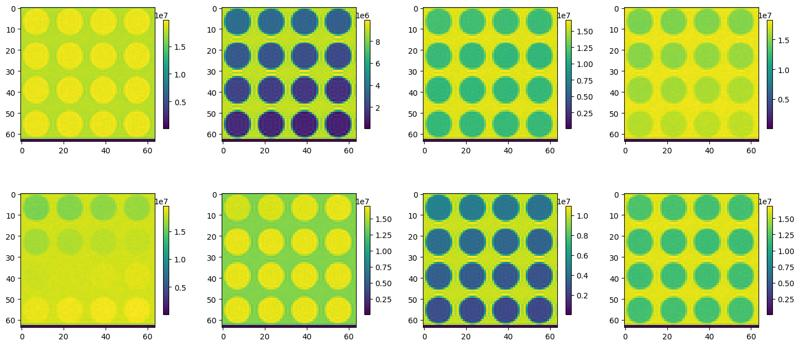

4096it [03:09, 21.67it/s]


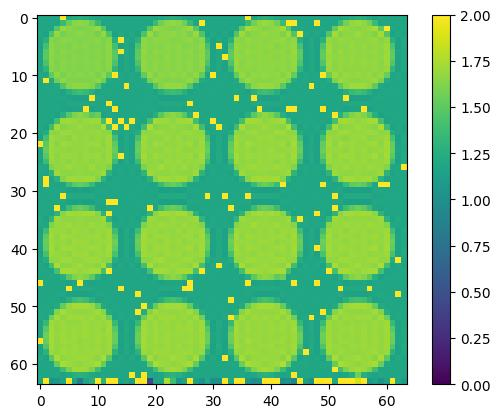

In [4]:
MOLLI_readout_img=[]
MOLLI_readout_t = np.array( [200, 1200, 2200, 3200, 4200, 300, 1300, 2300]) * 1e-3
for i in range(8):
    MOLLI_readout_img.append(load_img(
        "../exp_result_slow/ID0_Speed_min0.0_max0.01",i))
MOLLI_readout_img = np.asarray(MOLLI_readout_img)

# print(MOLLI_readout_img[:, 15, 15])

plt.figure(figsize=(18,8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(MOLLI_readout_img[i])
    plt.colorbar(shrink=0.7)
plt.show()

T1_result = np.zeros(MOLLI_readout_img[0].shape)

for x, y in tqdm(np.ndindex(MOLLI_readout_img[0].shape)):
    # T1_star, T1, A, B = MAGIR(
    T1_star, T1, A, B = MF_MAGIR(
        MOLLI_readout_t, MOLLI_readout_img[:, x, y])
    T1_result[x, y] = T1

# print(T1_result)
# T1_filter = median_filter(T1_result, size=3)


plt.figure()
plt.imshow(T1_result)
plt.colorbar()
plt.clim(0,2)